# 3.1 Attacking style & efficiency

In [2]:
%load_ext autoreload
%autoreload 2

# standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import json
import zipfile
from pathlib import Path
import os
import sys
from IPython.display import display

# specfic soccer analysis packages
from mplsoccer import Pitch, Sbopen, VerticalPitch

# load custom functions
from src.visualization import *

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Denmark vs Slovenia 2:1 (2023-11-20)

In [3]:
match_id = "5414302"
df_events = pd.read_csv(f"./results/wyscout/{match_id}_df_events.csv", index_col=0)

### Attacking style

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


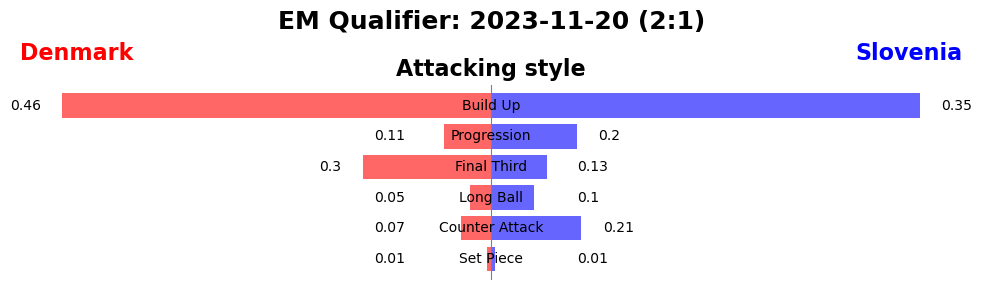

In [5]:
# Parameters for the analysis
final_third_start = 66.6
counter_attack_time_max = 15
progression_time_max = 20
build_up_time_min = 20
long_ball_min_length = 30
min_event_duration = 3

# Min requirement for attacking events: should be atleast 3s, and end in opposition third
df_events_att = df_events[(df_events['possession.duration'] >= min_event_duration) & \
                            (df_events['possession.endLocation.x'] > final_third_start)]


def categorize_event(row):
    if row['possession.duration'] < min_event_duration:
        return 'too_short'
    if row['type.primary'] in ['free_kick', 'corner', 'penalty'] and row['possession.startLocation.x'] > 50:
        return 'set_piece'
    elif row['type.primary'] == 'pass' and row['pass.length'] > long_ball_min_length and row['possession.startLocation.x'] < 50:
        return 'long_ball'
    elif row['possession.startLocation.x'] < 50 and row['possession.endLocation.x'] > final_third_start and row['possession.duration'] < counter_attack_time_max:
        return 'counter_attack'
    elif row['possession.startLocation.x'] < final_third_start and row['possession.endLocation.x'] > final_third_start and row['possession.duration'] < progression_time_max:
        return 'progression'
    elif row['possession.startLocation.x'] < final_third_start and row['possession.duration'] >= build_up_time_min:
        return 'build_up'
    elif row['possession.endLocation.x'] > final_third_start and row['possession.startLocation.x'] > final_third_start:
        return 'final_third_play'
    else:
        return 'other'

# Apply function to each row/event
df_events['category'] = df_events_att.apply(categorize_event, axis=1)

# Group by team and category
team_category_counts = df_events_att.groupby(['possession.team.name', 'category']).size().unstack(fill_value=0)

# Calculate the percentages for each category by team
team_category_perc = (team_category_counts.div(team_category_counts.sum(axis=1), axis=0)).round(2)

dnk_data = {'Build Up': team_category_perc.loc['Denmark', 'build_up'].round(2),
            'Progression': team_category_perc.loc['Denmark', 'progression'].round(2),
            'Final Third': team_category_perc.loc['Denmark', 'final_third_play'].round(2),
            'Long Ball': team_category_perc.loc['Denmark', 'long_ball'],
            'Counter Attack': team_category_perc.loc['Denmark', 'counter_attack'],
            'Set Piece': team_category_perc.loc['Denmark', 'set_piece'],
}

svn_data = {'Build Up': team_category_perc.loc['Slovenia', 'build_up'],
            'Progression': team_category_perc.loc['Slovenia', 'progression'],
            'Final Third': team_category_perc.loc['Slovenia', 'final_third_play'],
            'Long Ball': team_category_perc.loc['Slovenia', 'long_ball'],
            'Counter Attack': team_category_perc.loc['Slovenia', 'counter_attack'],
            'Set Piece': team_category_perc.loc['Slovenia', 'set_piece'],
}

# if category % do not normalize
perc_categories = ['Build Up', 'Progression', 'Final Third', 'Long Ball', 'Counter Attack', 'Set Piece']

plot_stats_barchart(svn_data, dnk_data, team1_name='Slovenia', team2_name='Denmark', perc_categories=perc_categories, title='EM Qualifier: 2023-11-20 (2:1)', 
                    subtitle='Attacking style', team1_color='blue', team2_color='red', saveplt=True, savepath='plots/3-attack/attacking_style.png')



### Attacking effciency

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


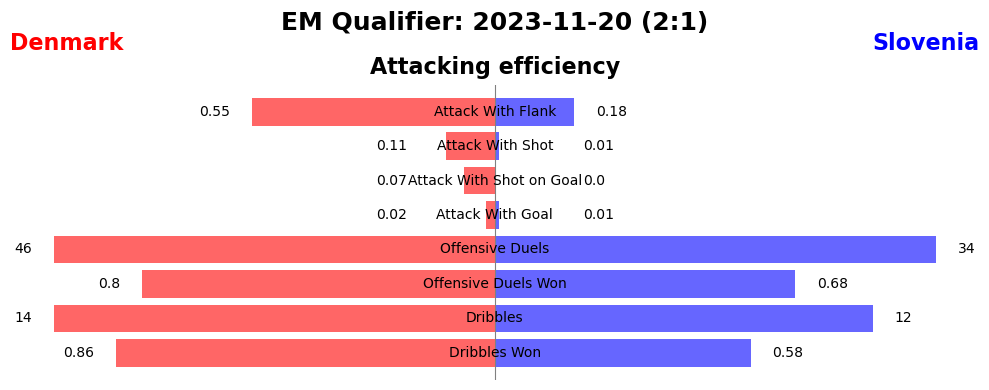

In [6]:
def calculate_attacking_efficiency(team_name):

    team_events = df_events[df_events["possession.team.name"] == team_name]

    # Attacks
    with_flank = team_events[(~team_events["possession.attack.flank"].isna())]['possession.id'].nunique()
    with_shot = team_events[(team_events["possession.attack.withShot"] == True)]['possession.id'].nunique()
    with_shot_on_target = team_events[(team_events["possession.attack.withShotOnGoal"] == True)]['possession.id'].nunique()
    with_goal = team_events[(team_events["possession.attack.withGoal"] == True)]['possession.id'].nunique()
    total_events = team_events["possession.id"].nunique()

    # Offensive Duels and Dribbles
    offensive_duels = team_events[(team_events["groundDuel.duelType"] == "offensive_duel")]
    offensive_duels_won = offensive_duels[offensive_duels["groundDuel.keptPossession"] == True]
    
    dribbles = team_events[(team_events["groundDuel.duelType"] == "dribble")]
    dribbles_won = dribbles[dribbles["groundDuel.keptPossession"] == True]
    

    
    return {
        'Attack With Flank': round(with_flank / total_events, 2),
        'Attack With Shot': round(with_shot / total_events, 2),
        'Attack With Shot on Goal': round(with_shot_on_target / total_events, 2),
        'Attack With Goal': round(with_goal / total_events, 2),
        'Offensive Duels': round(offensive_duels.shape[0], 2),
        'Offensive Duels Won': round(offensive_duels_won.shape[0] / offensive_duels.shape[0], 2),
        'Dribbles': round(dribbles.shape[0], 2),
        'Dribbles Won': round(dribbles_won.shape[0] / dribbles.shape[0], 2),
    }

# Use the function to calculate stats for Denmark and Slovenia
dnk_data = calculate_attacking_efficiency("Denmark")
svn_data = calculate_attacking_efficiency("Slovenia")

perc_categories = ["Attack With Flank", "Attack With Shot", "Attack With Shot on Goal", "Attack With Goal", "Offensive Duels Won", "Dribbles Won"]

plot_stats_barchart(svn_data, dnk_data, team1_name='Slovenia', team2_name='Denmark', perc_categories=perc_categories, title='EM Qualifier: 2023-11-20 (2:1)',
                    subtitle='Attacking efficiency', team1_color='blue', team2_color='red', saveplt=True, savepath='plots/3-attack/attacking_efficiency.png')